In [1]:
! pip install requests
! pip install pillow

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import sys
import tarfile
from io import BytesIO
from urllib import request
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Config #

# # Model #
FROZEN_GRAPH_NAME = 'frozen_inference_graph'
INPUT_TENSOR_NAME = 'ImageTensor:0'
OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
INPUT_SIZE = 512

# # Paths #
image_url = "https://images.unsplash.com/photo-1542362567-b07e54358753"
# ## Available pre-trained models:
# ## - http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
# ## - http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz
# ## - http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz
# ## - http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz
pretrained_model_url = "http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz"
pretrained_model_save_path = "./deeplab_model.tar.gz"

# # Globals #
ORIG_WIDTH, ORIG_HEIGHT = 0, 0

In [4]:
def read_image(path):
    """
    Read image from url or as file path.

    Parameters:
        path: URL or absolute/relative file path.

    Returns:
        Image object.
    """
    try:
        if is_url(path):
            return Image.open(BytesIO(requests.get(path).content))
        else:
            return Image.open(path)
    except IOError:
        print("Error during loading image.")
        sys.exit(1)

In [5]:
def is_url(possible_url): return urlparse(possible_url).scheme != ""

In [6]:
def download_pretrained_model(url, save_path):
    """
    Read image from url or as file path.

    Parameters:
        url: Pretrained model URL path.
        save_path: Absolute/Relative path where model will
        be saved.
    """
    request.urlretrieve(url, save_path)

In [7]:
def load_pretrained_model(tarfile_path):
    """
    Loads pre-trained model from compressed tar file.

    Parameters:
        tarfile_path: Path to the tarfile.

    Returns:
        Session of loaded pre-trained model.
    """
    graph = tf.Graph()

    graph_def = None
    tar_file = tarfile.open(tarfile_path)
    for tar_info in tar_file.getmembers():
        if FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
            file_handle = tar_file.extractfile(tar_info)
            graph_def = tf.GraphDef.FromString(file_handle.read())
            break
    tar_file.close()

    if graph_def is None:
        raise RuntimeError('Cannot find inference graph in tar archive.')

    with graph.as_default():
        tf.import_graph_def(graph_def, name='')

    return tf.Session(graph=graph)

In [8]:
def run_model(sess, image):
    """
    Runs model and generates object segmentation map.

    Parameters:
        sess: Loaded model session.
        image: Original image.

    Returns:
        Adopted segmentation map. Because model runs on smaller image
        size for performance benefits, in order to have segmentation map
        for original image this map needs to be resized.
    """
    batch_seg_map = sess.run(
        OUTPUT_TENSOR_NAME,
        feed_dict={INPUT_TENSOR_NAME: [np.asarray(normalize_image(image))]}
    )

    object_check = np.unique(batch_seg_map)
    if not np.array_equal(object_check, [0, 7]):
        raise RuntimeError('Car object isn\'t detected!')

    return adopt_segmentation(batch_seg_map[0])

In [9]:
def normalize_image(image):
    """
    Prepares image for model (normalize, convert, resize).

    Parameters:
        image: Original image.

    Returns:
        Normalized image.
    """
    global ORIG_WIDTH, ORIG_HEIGHT
    ORIG_WIDTH, ORIG_HEIGHT = image.size

    resize_ratio = 1.0 * INPUT_SIZE / max(ORIG_WIDTH, ORIG_HEIGHT)
    target_size = (int(resize_ratio * ORIG_WIDTH), int(resize_ratio * ORIG_HEIGHT))

    return image.convert('RGB').resize(target_size, Image.LANCZOS)

In [10]:
def adopt_segmentation(seg_map):
    """
    Adapts segmentation map to fit original image.

    Parameters:
        seg_map: Predicted segmentation map.

    Returns:
        Adopted segmentation map for original image.
    """
    seg_map = Image.fromarray((seg_map * 255).astype(np.uint8))
    seg_map = seg_map.convert("RGB")
    seg_map = seg_map.resize((ORIG_WIDTH, ORIG_HEIGHT), Image.LANCZOS)

    return seg_map

In [11]:
def preview_results(image, seg_map):
    """
    Saves image for preview purpose and displays it.

    Parameters:
        image: Original image.
        seg_map: Adopted segmentation map.
    """
    image.convert("RGB")
    overlay_img = Image.blend(image, seg_map, 0.5)
    overlay_img.save("overlay.png", "PNG")
    plt.rcParams['figure.figsize'] = [32, 16]
    plt.imshow(overlay_img)
    plt.show()

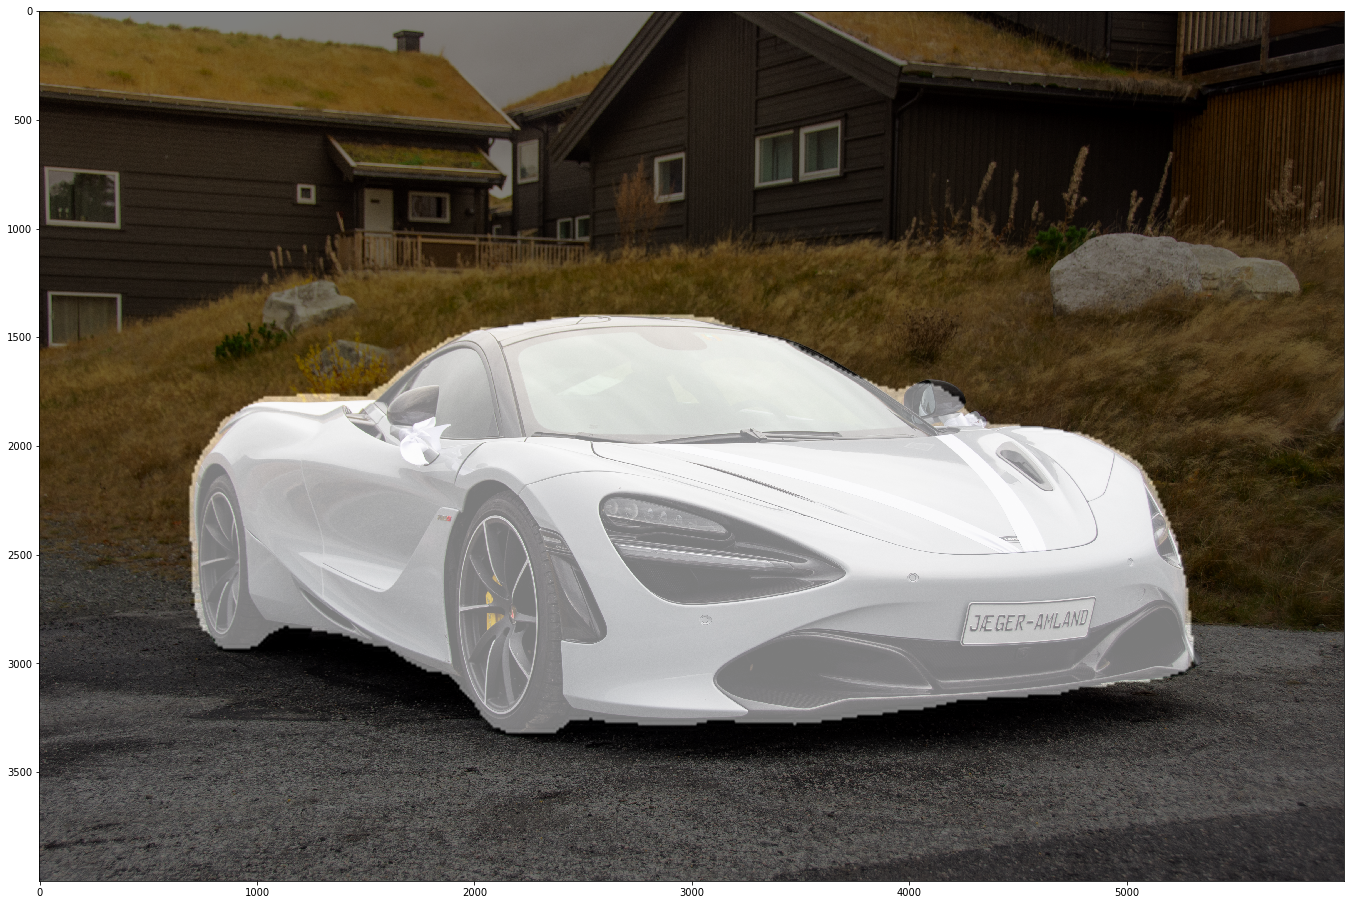

In [12]:
if __name__ == '__main__':
    original_image = read_image(image_url)
    download_pretrained_model(pretrained_model_url, pretrained_model_save_path)
    session = load_pretrained_model(pretrained_model_save_path)
    segmentation_map = run_model(session, original_image)
    preview_results(original_image, segmentation_map)